### MNIST Example

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

**Fetch the MNIST Dataset**

`Scikit-learn` provides many helper functions to download popular datasets. By default `Scikit-learn` caches downloaded datasets in a directory called `$HOME/scikit_learn_data`

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [12]:
x, y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

There are 70.000 images, and each image has 784 features (28x28 pixels)

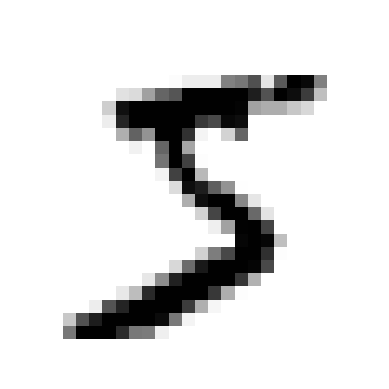

In [24]:
some_digit = x[0]
digit_image = some_digit.reshape(28, 28)

plt.imshow(digit_image, cmap='binary')
plt.axis('off')
plt.show()

The label is

In [16]:
y[0]

'5'

Cast stings into numerical values

In [19]:
y = y.astype(np.uint8)

Create a test set: the MNIST dataset is actually already split into a training set (the first 60.000 images) and a test set (the last 10.000 images). The training set is also already shuffled.

In [21]:
_SPLIT = 60000
x_train, x_test, y_train, y_test = x[:_SPLIT], x[_SPLIT:], y[:_SPLIT], y[_SPLIT:]

**Train a Binary Classifier**

Let's simplify the problem now and try to build "5-detector"

In [23]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

A good place to start is with a *Stochastic Gradient Descent* classifier

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

Evaluate our model

In [26]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Looks nice, or is it? Let's have a look at a *Constant* model for comparison

In [27]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    
    def fit(self, _: np.ndarray, y: np.ndarray) -> 'Never5Classifier':
        return self
    
    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.zeros((len(x), 1), dtype=bool)

    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This demonstrates why accuracy is generally not the preffered performance measure for classifiers, especially when you are dealing with a *skewed dataset*.

**Confusion Matrix**

Get the labels for each image using cross validation

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

Get the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in the matrix represents an *actual* class, while each column represents a *predicted* class. The first row considers non-5 images (the *negative* class):

|  | Predicted not-5 | Predicted 5 |
| --- | --- | --- |
| **Actual not-5** | TN  | FP  |
| **Actual 5** | FN  | TP  |

A perfect classifier would have onlu true positives and true negatives, so its confusion matrix would looks like

In [30]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

When the model claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

**Precision/Recall Trade-off**

Increasing precision reduces recall, and vice versa. The key concept is a moving decision threshold. Increasing the threshold increases precision and reduces recall. Conversely, lowering the threshold increases recall and reduses precision. We can observe it by controling the threshold manualy.

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [37]:
for threshold in (0, 8000):
    y_some_digit_pred = y_scores > threshold
    print(threshold, y_some_digit_pred)

0 [ True]
8000 [False]


How do you decide which treshold to use? First, get the scores of all samples in the training set

In [38]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

Compute precision and recall for all possible thresholds

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

And plot it

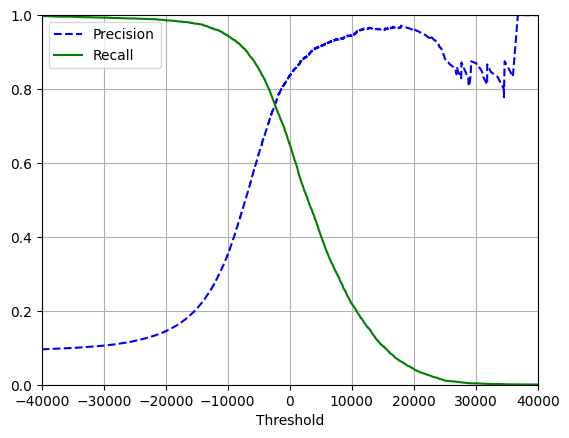

In [53]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.xlim(-40000, 40000)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly against recall

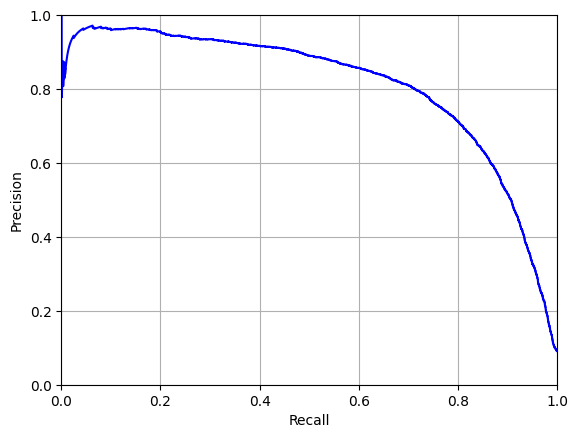

In [54]:
plt.plot(recalls[:-1], precisions[:-1], 'b-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.show()

Suppose you decide to aim for 90% precision. You can search for the lowest threshold that gives you at least 90%% precision:

In [55]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [56]:
y_train_pred_90 = y_scores >= threshold_90_precision
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.9000345901072293, 0.4799852425751706)

A high-precision classifier is not very usefull if its recall is too low.